# Volatility Modeling

## I. Data Analysis and Preprocessing

### I.1. Setup & Data Ingestion
First, we load the data from BigQuery as you requested. We'll use the BatchMarketIngestor logic found in your data/ingest.py or models/batch_run.py as a reference

### Import Libraries

#### Python Libraries

In [57]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from scipy import stats
from arch import arch_model

#### Local Libraries

In [58]:
# Get the absolute path to the project root (one directory up from 'notebooks')
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add it to sys.path if not already there
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data.market import MarketData

from src.models.volatility.lstm import lstm_fit, create_sequences_log, lstm_vol_prediction
from src.models.volatility.arima_garch import arima_fit, garch_fit, arima_garch_forecast

from src.utils.clean_data import clean_data
from src.utils.invariants import check_invariants

from src.evaluation.backtest import backtest


### Setup & Parameters

In [59]:
ticker = '^GSPC'  # Change to your desired asset
# ticker = 'CLP=X'
ticker = 'CL=F'
initial_date = '2020-01-01'
end_date = '2024-12-31'

market_data_source = 'bigquery'

# Define the "Stress Scenarios"
scenarios = {
    "Volmageddon (2018)":  ("2018-01-01", "2018-05-31"), # VIX Spike
    "Covid Crash (2020)":  ("2020-01-01", "2020-06-30"), # Pandemic
    "Inflation Bear (2022)": ("2022-01-01", "2022-12-31") # Slow Grind Down
}
scenario = "Covid Crash (2020)"
# scenario = "Inflation Bear (2022)"

date_range = scenarios[scenario]
start_date, end_date = date_range[0], date_range[1]

print(f"\n>>> Analyzing Regime: {scenario} ")
print(f"    Date Range for Backtesting: {start_date} to {end_date}")
# print(f"    Train Size: {len(train_data)} days | Test Size: {len(test_data)} days")


>>> Analyzing Regime: Covid Crash (2020) 
    Date Range for Backtesting: 2020-01-01 to 2020-06-30


c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Loaded 2711 rows for CL=F


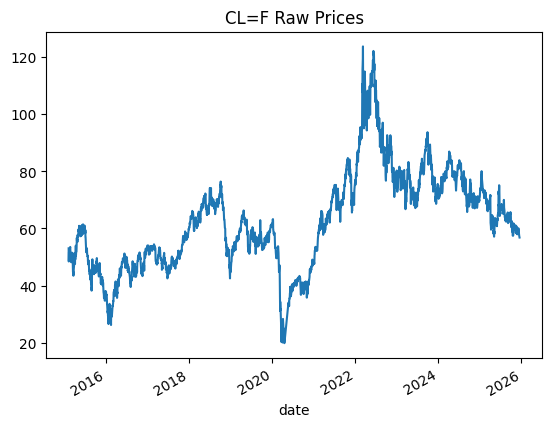

In [60]:
# Setup Project ID

if market_data_source == 'bigquery':
    PROJECT_ID = os.getenv("GOOGLE_CLOUD_PROJECT", "quant-ai-lab")
    client = bigquery.Client(project=PROJECT_ID)

    def load_data(ticker):
        """Fetches historical price data from BigQuery."""
        query = f"""
            SELECT date, price 
            FROM `{PROJECT_ID}.market_data.historical_prices`
            WHERE ticker = '{ticker}'
            ORDER BY date ASC
        """
        df = client.query(query).to_dataframe()
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df
    
    # Example Usage
    df = load_data(ticker)
    print(f"Loaded {len(df)} rows for {ticker}")
    df['price'].plot(title=f"{ticker} Raw Prices")
    plt.show()

### I.2. Data Cleaning (Outlier & NaN Analysis)
Before calculating returns, we must ensure the price series is clean. We check for NaNs and unrealistic price jumps (outliers) which might be data errors.

In [61]:
# Calculate Log Returns
df['log_ret'] = np.log(df['price'] / df['price'].shift(1))
df.dropna(inplace=True)

df_train = df.loc[df.index < start_date]
df_test = df.loc[(df.index >= start_date) & (df.index <= end_date)]

df_train_clean = clean_data(df_train,z_score_threshold=10)


### I.3. Calculate Invariants (Log Returns)
We calculate Log Returns, which are the candidate "Invariants" for our analysis.

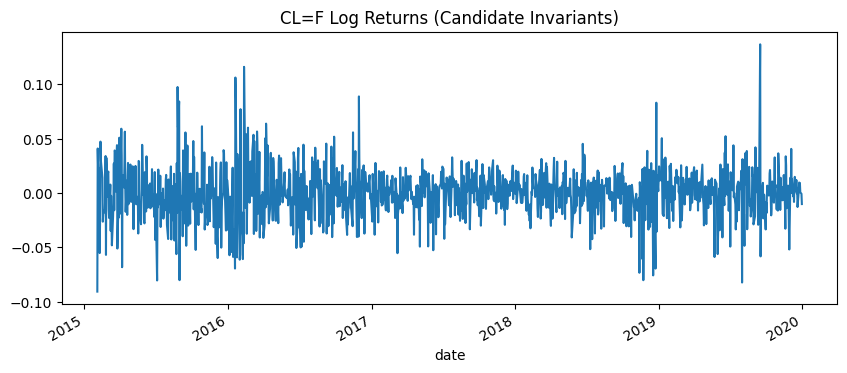

In [62]:
# Visualize
plt.figure(figsize=(10, 4))
df_train_clean['log_ret'].plot()
plt.title(f"{ticker} Log Returns (Candidate Invariants)")
plt.show()

### I.4. The Meucci "Check for Invariants"
This is the core statistical rigor step. According to Meucci, for a series to be a true invariant (i.i.d.), it must satisfy:

Independence: No autocorrelation (the past does not predict the future linearly).

Identical Distribution (Stability): The distribution properties (mean, variance) do not change over time.

In [63]:
# Run the test
is_independent, is_stable = check_invariants(df_train_clean['log_ret'])

--- Meucci Invariance Check ---
1. Independence (Ljung-Box): p-value = 0.1809
   ✅ PASS: Returns appear independent (No linear memory).
2. Stability (KS Test):      p-value = 0.0021
   ❌ FAIL: Structural break detected (Regime change/Clustering).


In [64]:
df_train_clean.index

DatetimeIndex(['2015-02-04 00:00:00+00:00', '2015-02-05 00:00:00+00:00',
               '2015-02-06 00:00:00+00:00', '2015-02-09 00:00:00+00:00',
               '2015-02-10 00:00:00+00:00', '2015-02-11 00:00:00+00:00',
               '2015-02-12 00:00:00+00:00', '2015-02-13 00:00:00+00:00',
               '2015-02-17 00:00:00+00:00', '2015-02-18 00:00:00+00:00',
               ...
               '2019-12-17 00:00:00+00:00', '2019-12-18 00:00:00+00:00',
               '2019-12-19 00:00:00+00:00', '2019-12-20 00:00:00+00:00',
               '2019-12-23 00:00:00+00:00', '2019-12-24 00:00:00+00:00',
               '2019-12-26 00:00:00+00:00', '2019-12-27 00:00:00+00:00',
               '2019-12-30 00:00:00+00:00', '2019-12-31 00:00:00+00:00'],
              dtype='datetime64[us, UTC]', name='date', length=1234, freq=None)

2020-01-01 00:00:00 2020-01-31 00:00:00

⚡ Fitting ARIMA(1,0,1)-GARCH(1,1) for VaR Projection...
Training LSTM on cpu...


c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

run model to  2020-01-01 00:00:00 2020-01-31 00:00:00
2020-02-01 00:00:00 2020-02-29 00:00:00

⚡ Fitting ARIMA(1,0,1)-GARCH(1,1) for VaR Projection...


c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

Training LSTM on cpu...
run model to  2020-02-01 00:00:00 2020-02-29 00:00:00
2020-03-01 00:00:00 2020-03-31 00:00:00

⚡ Fitting ARIMA(1,0,1)-GARCH(1,1) for VaR Projection...
Training LSTM on cpu...


c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will b

run model to  2020-03-01 00:00:00 2020-03-31 00:00:00
2020-04-01 00:00:00 2020-04-30 00:00:00

⚡ Fitting ARIMA(1,0,1)-GARCH(1,1) for VaR Projection...
Training LSTM on cpu...


c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

run model to  2020-04-01 00:00:00 2020-04-30 00:00:00
2020-05-01 00:00:00 2020-05-31 00:00:00

⚡ Fitting ARIMA(1,0,1)-GARCH(1,1) for VaR Projection...


c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

Training LSTM on cpu...
run model to  2020-05-01 00:00:00 2020-05-31 00:00:00
2020-06-01 00:00:00 2020-06-30 00:00:00

⚡ Fitting ARIMA(1,0,1)-GARCH(1,1) for VaR Projection...


c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will b

Training LSTM on cpu...
run model to  2020-06-01 00:00:00 2020-06-30 00:00:00
2020-07-01 00:00:00 2020-07-31 00:00:00


<Axes: xlabel='date'>

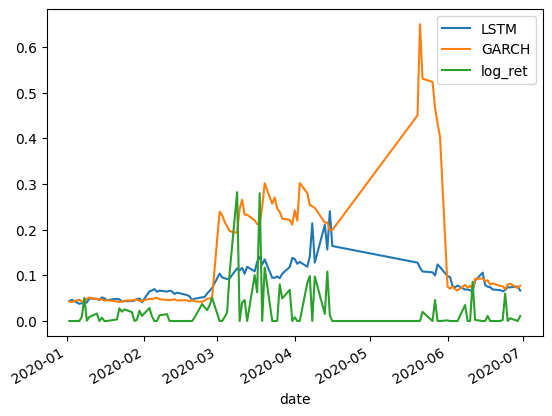

In [65]:
import datetime as dt
import pandas as pd
seq_len = 66

df.index = df.index.tz_localize(None)

date_aux_start = pd.Timestamp(start_date)
var_test = pd.DataFrame()
while True:
    date_aux_end = date_aux_start + pd.Timedelta(days=45)
    # Replace day=1 preserves timezone in pd.Timestamp
    date_aux_end = date_aux_end.replace(day=1)
    date_aux_end -= pd.Timedelta(days=1)
    print(date_aux_start, date_aux_end)

    if date_aux_start > pd.Timestamp(end_date):
        break
  
    df_train_aux = df.loc[:date_aux_start]['log_ret'].copy()
    df_test_aux = df.loc[date_aux_start: date_aux_end]['log_ret'].copy()
    garch_var_test = arima_garch_forecast(df_train_aux * 100, df_test_aux * 100) / 100
    model, calibrated_z, device = lstm_fit(df_train_aux, seq_len)
    lstm_vol_test = lstm_vol_prediction(df_train_aux, seq_len, df_test_aux, model, device)
    mu = float(df_train_aux.mean())
    lstm_var_test = -mu + lstm_vol_test * calibrated_z

    var_test_aux = pd.concat([lstm_var_test, garch_var_test], axis=1)
    var_test_aux.columns = ['LSTM', 'GARCH']
    # print('-'*10)
    # print(var_test_aux.index.min(), var_test_aux.index.max())
    # print('-'*10)
    # print(var_test_aux)
    
    var_test = pd.concat([var_test, var_test_aux], axis=0)
    print('run model to ', date_aux_start, date_aux_end)

    date_aux_start = date_aux_end + pd.Timedelta(days=1)

var_test = pd.concat([var_test, df['log_ret']], axis=1)
var_test.loc[var_test['log_ret'] > 0, 'log_ret'] = 0
var_test['log_ret'] = -var_test['log_ret']

# var_test['log_ret'] = -var_test['log_ret'].shift(1)

var_test.dropna(inplace=True)
var_test.plot()

<Axes: xlabel='date'>

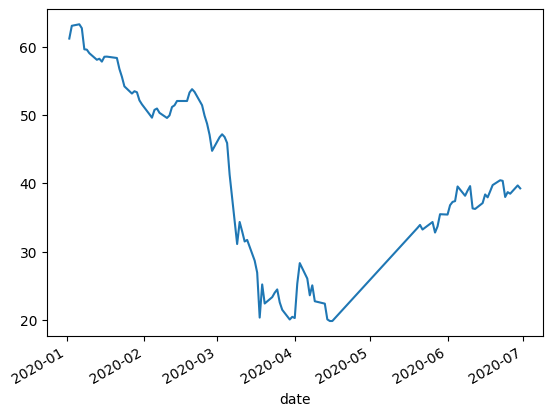

In [72]:
# df['price'].plot()
date_aux_start = pd.Timestamp(start_date)
date_aux_end = pd.Timestamp(end_date)
df.loc[date_aux_start:date_aux_end, 'price'].plot()

In [66]:
bt_results = var_test[['LSTM', 'GARCH']].copy()

bt_results['LSTM'] = 0
bt_results.loc[var_test['log_ret'] > var_test['LSTM'], 'LSTM'] = 1

bt_results['GARCH'] = 0
bt_results.loc[var_test['log_ret'] > var_test['GARCH'], 'GARCH'] = 1

bt_results.sum() / len(var_test)

LSTM     0.049020
GARCH    0.039216
dtype: float64

In [67]:
stop

NameError: name 'stop' is not defined

## II. ARIMA - GARCH Modeling
Conditional Modeling StrategyBased on the results of the Meucci test, we decide which model to apply.If Independent but Unstable: The mean is constant, but variance changes (Standard Volatility Clustering) $\to$ GARCH.If Dependent (Not Independent): There is linear memory $\to$ ARIMA.If Both Fail: We might need ARIMA-GARCH.

### II.1 ARIMA

In [ ]:
garch_var_test = arima_garch_forecast(df_train_clean['log_ret']*100, df_test['log_ret']*100, p=1, q=1, garch_p=1, garch_q=1, confidence_level=0.99)
garch_var_test /= 100


⚡ Fitting ARIMA(1,0,1)-GARCH(1,1) for VaR Projection...


c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

<Axes: xlabel='date'>

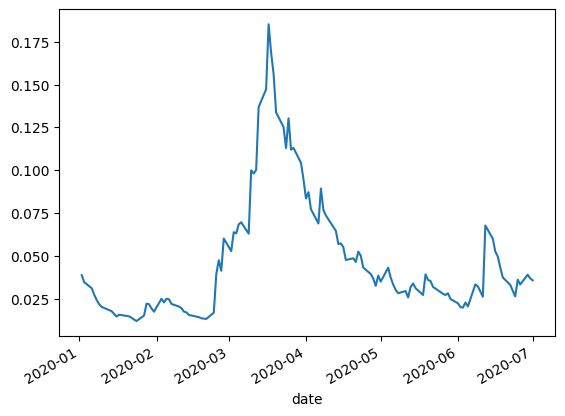

In [ ]:
garch_var_test.plot()

In [ ]:
# is_independent = False
# is_stable = False
# modeling_series, is_stable_resid = arima_fit(df_train_clean, is_independent, is_stable)
# is_stable_resid = False
# garch_fit(modeling_series, is_stable_resid)

### II.2 GARCH Baseline

## III. Deep LSTM Modeling

8. The Challenger: Deep LSTM Definition
First, we define the neural network architecture and the custom loss function directly in the notebook. This logic is adapted from your src/models/lstm.py.

9. Training & Forecasting
Now we train the model on the data.

<Axes: xlabel='date'>

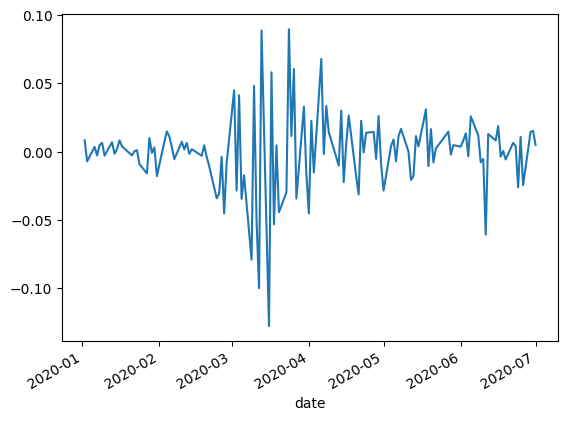

In [ ]:
df_test['log_ret'].plot()

In [ ]:
# 1. Prepare Data
seq_len = 66

model, calibrated_z, device = lstm_fit(df_train_clean['log_ret'], seq_len)
lstm_vol_test = lstm_vol_prediction(df_train_clean['log_ret'], seq_len, df_test['log_ret'], model, device)

Training LSTM on cpu...


In [ ]:
mu = float(df_train_clean['log_ret'].mean())
lstm_var_test = -mu + lstm_vol_test * calibrated_z
lstm_var_test

date
2020-01-02 00:00:00+00:00    0.006154
2020-01-03 00:00:00+00:00    0.005228
2020-01-06 00:00:00+00:00    0.007697
2020-01-07 00:00:00+00:00    0.008486
2020-01-08 00:00:00+00:00    0.011655
                               ...   
2020-06-25 00:00:00+00:00    0.026388
2020-06-26 00:00:00+00:00    0.023761
2020-06-29 00:00:00+00:00    0.025911
2020-06-30 00:00:00+00:00    0.022649
2020-07-01 00:00:00+00:00    0.018324
Name: LSTM_Vol, Length: 126, dtype: float32

<Axes: xlabel='date'>

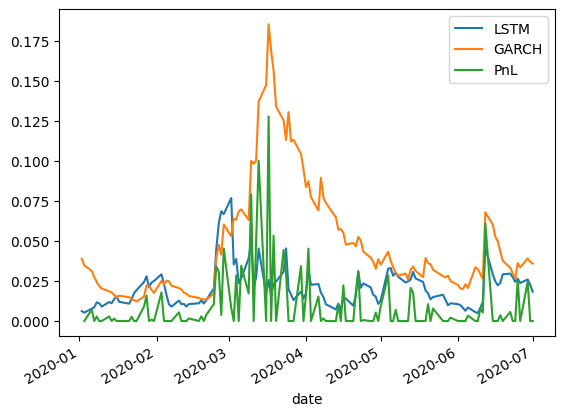

In [ ]:
var_test = pd.concat([lstm_var_test, garch_var_test, df_test['log_ret']], axis=1)
var_test.columns = ['LSTM', 'GARCH', 'PnL']
var_test.loc[var_test['PnL'] > 0, 'PnL'] = 0
var_test['PnL'] = -var_test['PnL'].shift(1)

var_test.plot()

In [ ]:
len(var_test)

126

In [ ]:
var_test

,LSTM,GARCH,log_ret
date,,,
2020-01-03,0.014800,0.016037,-0.000000
2020-01-06,0.021028,0.016709,0.007085
2020-01-07,0.017332,0.015353,-0.000000
2020-01-08,0.020411,0.014491,0.002807
2020-01-09,0.017436,0.013949,-0.000000
...,...,...,...
2020-06-29,0.034297,0.032189,0.024525
2020-06-30,0.024539,0.038230,-0.000000
2020-07-01,0.017944,0.038573,-0.000000


In [ ]:
bt_results = var_test[['LSTM', 'GARCH']].copy()

bt_results['LSTM'] = 0
bt_results.loc[var_test['log_ret'] > var_test['LSTM'], 'LSTM'] = 1

bt_results['GARCH'] = 0
bt_results.loc[var_test['log_ret'] > var_test['GARCH'], 'GARCH'] = 1

bt_results.sum() / len(var_test)


LSTM     0.069231
GARCH    0.000000
dtype: float64

## IV. Scenario-Based Backtesting
This block iterates through major market crises. For each crisis:

It defines Train Data as everything before the crisis (the model learns "normal" behavior).

It defines Test Data as the crisis period itself (the model faces "abnormal" behavior).

It compares GARCH (fixed parameters) vs. Historical Volatility (adaptive window) vs. LTSM (adaptive window) to see which breaks first.

### IV.1 Stress Scenarios Definition

In [ ]:
# Configuration for VaR
portfolio_value = 1_000_000
confidence_level = 2.33 # 99% Confidence

results = []

print(f"\n{'='*20} SCENARIO BACKTEST RESULTS {'='*20}")

for regime_name, (start_date, end_date) in scenarios.items():
    results.append(backtest(portfolio_value, confidence_level, df_clean, start_date, end_date, regime_name))


==================== SCENARIO BACKTEST RESULTS ====================

>>> Analyzing Regime: Volmageddon (2018)
    Train Size: 733 days | Test Size: 105 days
Training LSTM on cpu...
LSTM Breaches: 5 / 105
    GARCH Breach Rate:      2.86%  (Target: 1.0%)
    Historical Breach Rate: 3.81%
    LSTM Breach Rate:       4.76%

>>> Analyzing Regime: Covid Crash (2020)
    Train Size: 1236 days | Test Size: 126 days
Training LSTM on cpu...
LSTM Breaches: 19 / 126
    GARCH Breach Rate:      3.97%  (Target: 1.0%)
    Historical Breach Rate: 7.14%
    LSTM Breach Rate:       15.08%

>>> Analyzing Regime: Inflation Bear (2022)
    Train Size: 1741 days | Test Size: 251 days
Training LSTM on cpu...
LSTM Breaches: 5 / 251
    GARCH Breach Rate:      2.79%  (Target: 1.0%)
    Historical Breach Rate: 1.59%
    LSTM Breach Rate:       1.99%
